# K-Means Clustering and K Nearest Neighbors Project

Jump to:
* [K Means clustering model](#kmeans)
* [K Nearest Neighbors model](#kneighbor)

## About the dataset

<img src="https://previews.123rf.com/images/aomeditor/aomeditor1903/aomeditor190300021/122254680-illustrator-of-body-parts-of-penguin.jpg" height='400px' width='400px'>

### <b>Columns in the dataset</b>
<ul>
    <li><b>Species: </b>penguin species (Chinstrap, Adélie, or Gentoo)</li>
    <li><b>Island: </b>island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)</li>
    <li><b>culmen_length_mm: </b>culmen length (mm)</li>
    <li><b>culmen_depth_mm: </b>culmen depth (mm)</li>
    <li><b>flipper_length_mm: </b>flipper length (mm)</li>
    <li><b>body_mass_g: </b>body mass (g)</li>
    <li><b>Sex: </b>penguin sex</li>
</ul>

In [1]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data = pd.read_csv('../input/palmer-archipelago-antarctica-penguin-data/penguins_size.csv')
# Check the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [3]:
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


# EDA

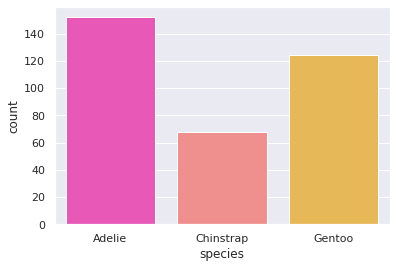

In [4]:
sns.countplot(data['species'],palette='spring');

Our data is not balanced. As data is not big enough so I will not balance it.

In case of unbalanced data we can either up-sample minority class or down-sample majority class. To see an example see my following notebooks:
* [up-sampling-minority-class](https://www.kaggle.com/ayushikaushik/up-sampling-to-tackle-unbalanced-dataset)
* [down-sampling-majority-class](https://www.kaggle.com/ayushikaushik/down-sampling-majority-class-6-classification-algo)

To know cons of imbalanced data and more ways to handle it, read [this](https://elitedatascience.com/imbalanced-classes) article.

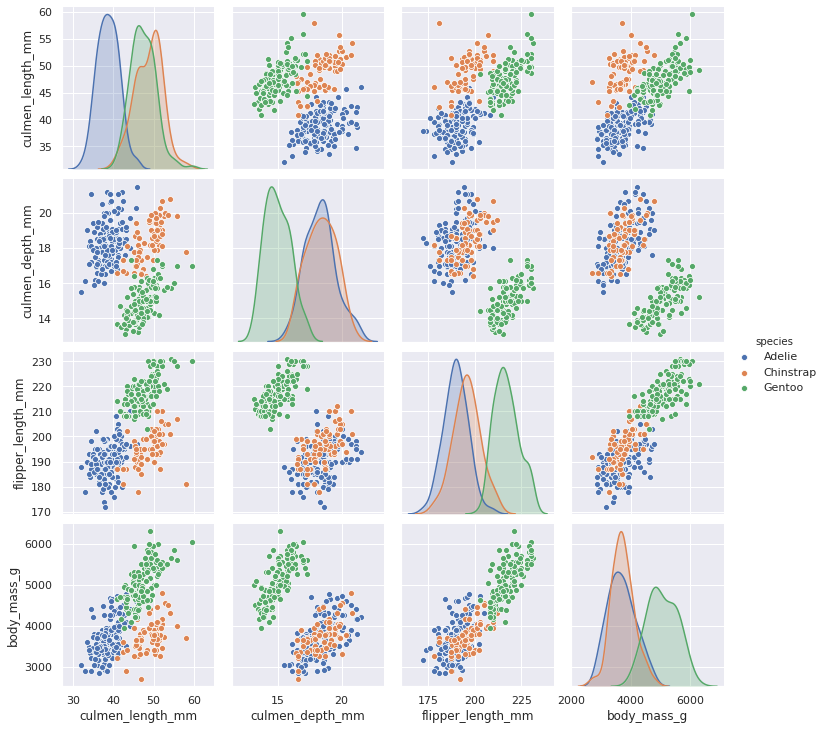

In [5]:
sns.pairplot(data,hue='species');

We can see clusters are easily separable in the cases:
1. culmen_length_mm  vs  culmen_depth_mm ;
2. culmen_length_mm  vs  flipper_length_mm ;
3. culmen_length_mm  vs  body_mass_g.

Let's explore distribution of our data.


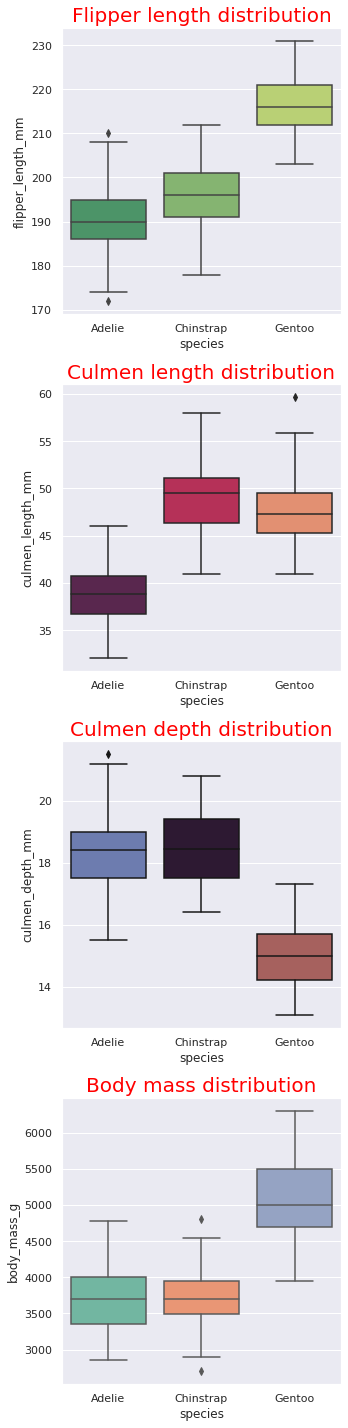

In [6]:
print("Let's explore distribution of our data.")
fig,axes=plt.subplots(4,1,figsize=(5,20))
sns.boxplot(x=data.species,y=data.flipper_length_mm,ax=axes[0],palette='summer')
axes[0].set_title("Flipper length distribution",fontsize=20,color='Red')
sns.boxplot(x=data.species,y=data.culmen_length_mm,ax=axes[1],palette='rocket')
axes[1].set_title("Culmen length distribution",fontsize=20,color='Red')
sns.boxplot(x=data.species,y=data.culmen_depth_mm,ax=axes[2],palette='twilight')
axes[2].set_title("Culmen depth distribution",fontsize=20,color='Red')
sns.boxplot(x=data.species,y=data.body_mass_g,ax=axes[3],palette='Set2')
axes[3].set_title("Body mass distribution",fontsize=20,color='Red')
plt.tight_layout();

In [7]:
print("Mean body mass index distribution")
data.groupby(['species','sex']).mean()['body_mass_g'].round(2)

Mean body mass index distribution


species    sex   
Adelie     FEMALE    3368.84
           MALE      4043.49
Chinstrap  FEMALE    3527.21
           MALE      3938.97
Gentoo     .         4875.00
           FEMALE    4679.74
           MALE      5484.84
Name: body_mass_g, dtype: float64

### Dealing with missing values

Let's check out the percentage of missing values.

In [8]:
100*data.isnull().sum()/len(data)

species              0.000000
island               0.000000
culmen_length_mm     0.581395
culmen_depth_mm      0.581395
flipper_length_mm    0.581395
body_mass_g          0.581395
sex                  2.906977
dtype: float64

Percentage of missing data is very less. Let's impute it with median in numerical features and mode in categorical feature.
Here, I have used .fillna method from pandas library.

Missing values can also be filled using pre-defined functions like SimpleImputer from sklearn.

In [9]:
data['sex'].fillna(data['sex'].mode()[0],inplace=True)
col_to_be_imputed = ['culmen_length_mm', 'culmen_depth_mm','flipper_length_mm', 'body_mass_g']
for item in col_to_be_imputed:
    data[item].fillna(data[item].mean(),inplace=True)

### Dealing with categorical features

In [10]:
data.species.value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

In [11]:
data.island.value_counts()

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

In [12]:
data.sex.value_counts()

MALE      178
FEMALE    165
.           1
Name: sex, dtype: int64

Oops! Where did this '.' entry came from?

In [13]:
data[data['sex']=='.']

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


In [14]:
data.loc[336,'sex'] = 'FEMALE'

In [15]:
# Target variable can also be encoded using sklearn.preprocessing.LabelEncoder
data['species']=data['species'].map({'Adelie':0,'Gentoo':1,'Chinstrap':2})

# creating dummy variables for categorical features
dummies = pd.get_dummies(data[['island','sex']],drop_first=True)

### Standardizing feature variables.

In [16]:
# we do not standardize dummy variables 
df_to_be_scaled = data.drop(['island','sex'],axis=1)
target = df_to_be_scaled.species
df_feat= df_to_be_scaled.drop('species',axis=1)

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_feat)
df_scaled = scaler.transform(df_feat)
df_scaled = pd.DataFrame(df_scaled,columns=df_feat.columns[:4])
df_preprocessed = pd.concat([df_scaled,dummies,target],axis=1)
df_preprocessed.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_MALE,species
0,-8.870812e-01,7.877425e-01,-1.422488,-0.565789,0,1,1,0
1,-8.134940e-01,1.265563e-01,-1.065352,-0.503168,0,1,0,0
2,-6.663195e-01,4.317192e-01,-0.422507,-1.192003,0,1,0,0
3,1.307172e-15,1.806927e-15,0.000000,0.000000,0,1,1,0
4,-1.328605e+00,1.092905e+00,-0.565361,-0.941517,0,1,0,0


## <a id='kmeans'>K-Means Clustering</a>

It is very important to note, we actually have the labels for this data set, but we will NOT use them for the K-Means clustering algorithm, since that is an **unsupervised learning algorithm**. K-means is a centroid-based algorithm, or a distance-based algorithm, where we calculate the distances to assign a point to a cluster. In K-Means, each cluster is associated with a centroid. The main objective of the K-Means algorithm is to minimize the sum of distances between the points and their respective cluster centroid.

K Means Clustering is an unsupervised learning algorithm that tries to cluster data based on their similarity. Unsupervised learning means that there is no outcome to be predicted, and the algorithm just tries to find patterns in the data. In k means clustering, we have to specify the ***number of clusters k*** we want the data to be grouped into.

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

kmeans = KMeans(3,init='k-means++')
kmeans.fit(df_preprocessed.drop('species',axis=1))
print(confusion_matrix(df_preprocessed.species,kmeans.labels_))

[[ 11   0 141]
 [  1 123   0]
 [ 63   0   5]]


> Running above cell again and again gives different results each time. While making this notebook, best accuracy wass 95%. After commiting, it can show anything. I don't know how to handle this.

In [19]:
print(classification_report(df_preprocessed.species,kmeans.labels_))

              precision    recall  f1-score   support

           0       0.15      0.07      0.10       152
           1       1.00      0.99      1.00       124
           2       0.03      0.07      0.05        68

    accuracy                           0.40       344
   macro avg       0.39      0.38      0.38       344
weighted avg       0.43      0.40      0.41       344



In [20]:
f"Accuracy is {np.round(100*accuracy_score(df_preprocessed.species,kmeans.labels_),2)}"

'Accuracy is 40.41'

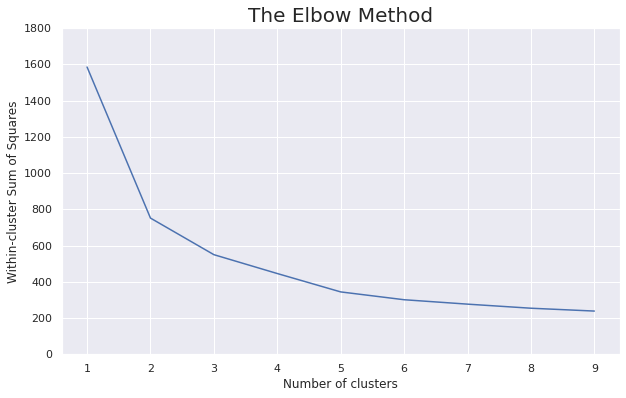

In [21]:
wcss=[]
for i in range(1,10):
    kmeans = KMeans(i)
    kmeans.fit(df_preprocessed.drop('species',axis=1))
    pred_i = kmeans.labels_
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1,10),wcss)
plt.ylim([0,1800])
plt.title('The Elbow Method',{'fontsize':20})
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares');

We can observe from graph that as k goes from 1 to 3 there is a steep decline in wcss. As k increases further decrease in k becomes linear. So, k=3 is a good choice.

## <a id ='kneighbor'>K-Nearest Neighbours Classification</a>

It is a **supervised learning algorithm** which can be used for both classification and regression predictive problems. However, it is more widely used in classification problems in the industry.

With the given data, KNN can classify new, unlabelled data by analysis of the ***k number of the nearest data points***.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# We need to split data for supervised learning models.
X_train, X_test, y_train, y_test = train_test_split(df_preprocessed.drop('species',axis=1),target,test_size=0.50)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
preds_knn = knn.predict(X_test)
print(confusion_matrix(y_test,preds_knn))

[[78  0  1]
 [ 1 61  0]
 [ 0  0 31]]


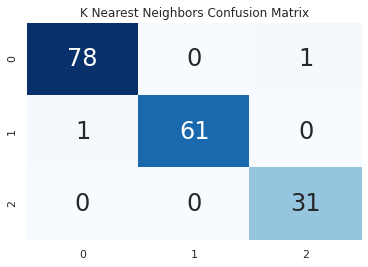

In [23]:
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,preds_knn),annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24});

In [24]:
print(classification_report(y_test,preds_knn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        79
           1       1.00      0.98      0.99        62
           2       0.97      1.00      0.98        31

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172



In [25]:
print(accuracy_score(y_test,preds_knn))

0.9883720930232558


In [26]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(knn.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(knn.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.9884


**Figuring out best value for k**

In [27]:
error_rate=[]
for i in range(1,10):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i!=y_test))

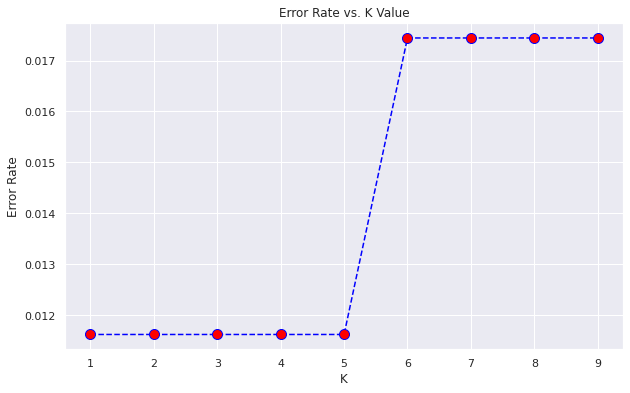

In [28]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate');

From the graph, we can notice that best vaalue for k is 6.

**Best Model:**

In [29]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train,y_train)
preds_knn = knn.predict(X_test)
print(confusion_matrix(y_test,preds_knn))
print(classification_report(y_test,preds_knn))

[[78  0  1]
 [ 1 61  0]
 [ 1  0 30]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        79
           1       1.00      0.98      0.99        62
           2       0.97      0.97      0.97        31

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172



So, we achieved 99% accuracy.